# Compare Demographics across the four Datasites

As our first step in our analyses, we want to collect information about the demographics in each dataset.

> 💡 This information is crucial to understand possible differences in data distributions, and therefore how data
varies across the four Hospitals! (another good reason to appreciate the benefits from working with **more data**).

Naturally, we can't collect this information from _mock_ data! But we can use mock to prepare our code. Afterwards, we will send a request on each datasite to gather the **true** statistics we're interested in.

## Step 1. Login to datasites as **External Researcher**

Launch Datasites if not running:
```bash
$ python launch_datasites.py
```

In [1]:
import syft as sy

In [2]:
from datasites import DATASITE_URLS

datasites = {}
for name, url in DATASITE_URLS.items():
    datasites[name] = sy.login_as_guest(url=url)

Logged into <Cleveland Clinic: High-side Datasite> as GUEST
Logged into <Hungarian Inst. of Cardiology: High-side Datasite> as GUEST
Logged into <Univ. Hospitals Zurich and Basel: High-side Datasite> as GUEST
Logged into <V.A. Medical Center: High-side Datasite> as GUEST


## Step 2. Get Mock data and prepare your data science code

In [3]:
dataset = datasites["Cleveland Clinic"].datasets["Heart Disease Dataset"]
dataset.description


## Heart Disease Dataset

**Institute**: Clevelan Clinic, Ohio (USA)

**Descriptive Statistics** (demographics removed):

|       |         cp |   trestbps |     chol |        fbs |    restecg |   thalach |      exang |   oldpeak |      slope |         ca |      thal |        num |
|:------|-----------:|-----------:|---------:|-----------:|-----------:|----------:|-----------:|----------:|-----------:|-----------:|----------:|-----------:|
| count | 303        |   303      | 303      | 303        | 303        |   303     | 303        | 303       | 303        | 299        | 301       | 303        |
| mean  |   3.15842  |   131.69   | 246.693  |   0.148515 |   0.990099 |   149.607 |   0.326733 |   1.0396  |   1.60066  |   0.672241 |   4.73422 |   0.937294 |
| std   |   0.960126 |    17.5997 |  51.7769 |   0.356198 |   0.994971 |    22.875 |   0.469794 |   1.16108 |   0.616226 |   0.937438 |   1.93971 |   1.22854  |
| min   |   1        |    94      | 126      |   0        |   0        |    71     |   0        |   0       |   1        |   0        |   3       |   0        |
| 25%   |   3        |   120      | 211      |   0        |   0        |   133.5   |   0        |   0       |   1        |   0        |   3       |   0        |
| 50%   |   3        |   130      | 241      |   0        |   1        |   153     |   0        |   0.8     |   2        |   0        |   3       |   0        |
| 75%   |   4        |   140      | 275      |   0        |   2        |   166     |   1        |   1.6     |   2        |   1        |   7       |   2        |
| max   |   4        |   200      | 564      |   1        |   2        |   202     |   1        |   6.2     |   3        |   3        |   7       |   4        |

**Demographics**:

- `age`: Integer, _age in years_
- `sex`: Categorical, `1 = male; 0 = female`

**Outcome**:

- `num`: Integer, _Angiographic Disease Status_
    - Diagnosis: Absence (`num = 0`); Presence (`num &gt; 0`) 


_From the dataset description_: the `age`, and `sex` columns corresponds to the demographics in our dataset, while the `num` column is the outcome of the study. 

Let's download the mock data to start working our code!

> 💡 Remeber: Mock data is an _artificially created_ version of the true (non-public) data that is only meant for code prototyping!

In [4]:
mock_data = dataset.assets["Heart Study Data"].mock

In [5]:
mock_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,70,1,4,85,527,0,1,80,0,4.7,3,1.0,7.0,0
1,66,1,4,85,563,0,0,94,0,-1.7,1,2.0,3.0,2
2,69,1,3,92,186,1,0,160,1,1.3,1,0.0,7.0,2
3,32,0,1,165,161,0,1,60,1,1.6,2,1.0,7.0,0
4,5,1,4,134,318,0,0,204,1,1.0,2,0.0,3.0,2


We can do some `pandas` [**magic**](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html) to generate statistics about the _disease prevalance_ in the dataset, aggregated by the demographics (`age`, `sex`)

In [6]:
import pandas as pd

def aggregate_factors(data):
    """Gather demographics categorical factors from data:
    - Age will be mapped to three Age Ranges
    - New Diagnosis column for binary outcome of the study (and better plotting legends)
    - New Sex-Label column to better decode the `sex` column in data.
    """
    info = pd.DataFrame()
    info["diagnosis"] = data["num"].map(lambda v: "present" if v > 0 else "absent")
    info["sex-label"] = data["sex"].map({0: "female", 1: "male"})

    age_range = lambda v: "0-40" if v < 40 else "40-65" if v <= 65 else "Over 65"
    info["age-range"] = pd.Categorical(data["age"].apply(age_range), 
                                       categories=["0-40", "40-65", "Over 65"],
                                       ordered=True)
    return info

def disease_prevalence_per_demographic(data):
    cats = aggregate_factors(data)
    prevalence_by_demographics = pd.crosstab(
        index = cats["age-range"], columns = [cats["sex-label"], cats["diagnosis"]],
    )
    return prevalence_by_demographics

disease_prevalence_per_demographic(mock_data)

sex-label female           male        
diagnosis absent present absent present
age-range                              
0-40           7      24      7      45
40-65          5      23      6      22
Over 65        7      34      9      30

## Step 3. Run code remotely on all datasites

Let's now rewrite our `disease_prevalence_per_demographic` function to be **self-contained**: 

> All dependencies necessary for the execution must be defined within the body of the function.

In [7]:
for name, datasite in datasites.items():
    # data asset on the DataSite
    data_asset = datasite.datasets["Heart Disease Dataset"].assets["Heart Study Data"]  
    
    @sy.syft_function_single_use(data=data_asset)
    def disease_prevalence_per_demographic(data) -> pd.DataFrame:
        # third party dependency
        import pandas as pd
        
        def aggregate_factors():
            info = pd.DataFrame()
            info["diagnosis"] = data["num"].map(lambda v: "present" if v > 0 else "absent")
            info["sex-label"] = data["sex"].map({0: "female", 1: "male"})
        
            age_range = lambda v: "0-40" if v < 40 else "40-65" if v <= 65 else "Over 65"
            info["age-range"] = pd.Categorical(
                data["age"].apply(age_range),
                categories=["0-40", "40-65", "Over 65"],
                ordered=True,
            )
            return info
        
        cats = aggregate_factors()
        prevalence_by_demographics = pd.crosstab(
            index = cats["age-range"], columns = [cats["sex-label"], cats["diagnosis"]],
        )
        return prevalence_by_demographics

    # Submit simple code request
    datasite.code.request_code_execution(disease_prevalence_per_demographic)

SyftSuccess: Syft function 'disease_prevalence_per_demographic' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'disease_prevalence_per_demographic' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'disease_prevalence_per_demographic' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'disease_prevalence_per_demographic' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

In [8]:
# Check status of requests
from utils import check_status_last_code_requests

check_status_last_code_requests(datasites)

Datasite: Cleveland Clinic


SyftSuccess: <class 'syft.service.code.user_code.UserCodeStatusCollection'> approved

Datasite: Hungarian Inst. of Cardiology


SyftSuccess: <class 'syft.service.code.user_code.UserCodeStatusCollection'> approved

Datasite: Univ. Hospitals Zurich and Basel


SyftSuccess: <class 'syft.service.code.user_code.UserCodeStatusCollection'> approved

Datasite: V.A. Medical Center


SyftSuccess: <class 'syft.service.code.user_code.UserCodeStatusCollection'> approved

🎉 All requests should be all (automatically) `APPROVED`! (_If that's not the case, check again until are all approved_)

## Step 4. Gather results from all datasites 

In [9]:
demographics = {}
for name, datasite in datasites.items():
    data_asset = datasite.datasets["Heart Disease Dataset"].assets["Heart Study Data"]
    data_stats = datasite.code.disease_prevalence_per_demographic(data=data_asset).get_from(datasite) # use .get_from() to download the result
    demographics[name] = data_stats

Let's now compare statistics across the **four datasets**, and plot the results for clearer insights and comparisons:

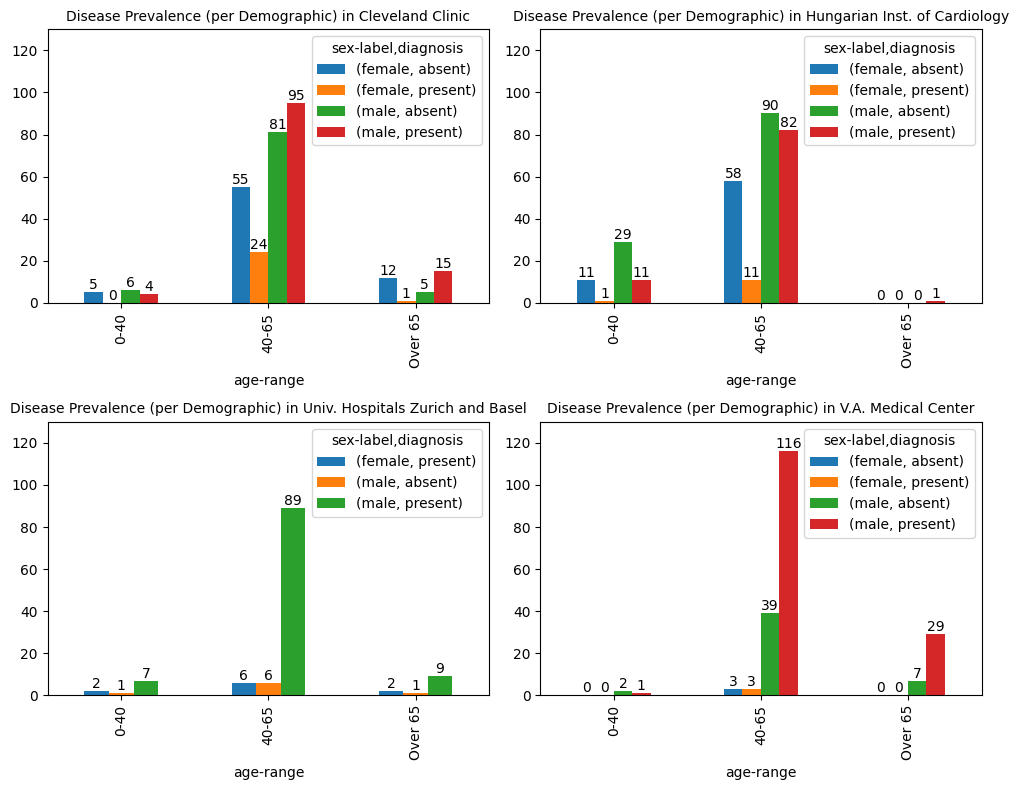

In [10]:
# Let's plot the result for better visualisation
from matplotlib import pyplot as plt
from itertools import product

def plot_disease_prevalence(axis, data, name) -> None:
    data.plot.bar(ax=axis)
    for container in axis.containers:
        axis.bar_label(container)
    axis.set_ylim([0, 130])
    axis.set_title(f"Disease Prevalence (per Demographic) in {name}", fontsize = "medium")

fig, axes = plt.subplots(2, 2, figsize=(10,8))

for coords, (name, data) in zip(product(range(2), repeat=2), demographics.items()):
    plot_disease_prevalence(axis=axes[*coords], data=data, name=name)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Conclusions

Data distributions across the four datasets/datasites is very different - which means that we may expect different results when training classifiers on each dataset.

Moreover, apart from the dataset in the "Cleveland Clinic", we have discovered that `age` is **not** likely to be a good indicator for data partitioning, as data is too skew, if combined with other demographics!

Let's now continue our analyses with some Machine learning modelling!

### Final Remarks

In this example, the **true** statistics about the data are returned. This is a fair assumption, considering the data we are working with. However, in more realistic scenarios, additional **PET**s (**P**rivacy **E**nhancing **T**echnologies) could be used to better protect the privacy of the data. In fact, these are exactly the types of query that techniques like [Differential Privacy](https://opendp.org/about) can help with! 

I will definitely show you how to use `DP` with PySyft in another tutorial! But in the meantime, please feel free to try it yourself, and then send a new [PR](https://github.com/OpenMined/syft-heart-disease-tutorial/pulls) to contribute to this tutorial!